In [1]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

# Becoming a successful Data Scientist

As of now, you should know
- how to construct models (the "recipe")
- how to use them for prediction
- some simple metrics on how they perform

But, to a degree, this knowledge is purely knowing the mechanics.
Perhaps having answers to the following questions is *the most important* topic from this course

- How can you *improve* your models ?
- How can you tell if your model's predictions "make sense"
- How can I be most productive ?

In this module, the topics to be covered provide answers:
- model diagnostics and interpretation
    - What is the model fit telling you ?
        - need to understand model math
    - What should you do about it
        - Transformations
- data cleaning, munging


We will illustrate this with a running example: MNIST digit classification

<div class="alert alert-block alert-warning">
    We will <i>illustrate</i> many points using the `LinearRegression` and `LogisticRegression` models.
<ul>
    <li>you presumably have at least some (i.e., more than other models) exposure/understanding</li>
    <li>"Classical ML" has a well-developped statistical background</li>  
</ul>
    The goal is <b>not</b> to make you an expert in Regression.
    These are only illustrations; many concepts carry over to other models.
</div>

# Model diagnostics

- Beyond summary statistics
    - for classification
    - for regression
- What is a "good" value for the summary statistic


## Classification: Beyond accuracy

Recall that we previewed the "confusion matrix" in the previous lecture.

This is how we explore model errors for **classification** problems.

Let's re-run the MNIST problem and examine measures of error more detailed than accuracy

Load the image data

In [2]:
# %load mnist_1.py
import time
import matplotlib.pyplot as plt
import numpy as np
 
import os
 
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

from sklearn import datasets, svm, metrics

import os

def fetch_mnist_784():
    # The fetch from the remote site is SLOW b/c the data is so big
    # Try getting it from a local cache
    cache_dir = "cache/mnist_784"
    (X_file, y_file) = [ "{c}/{f}.npy".format(c=cache_dir, f=fn) for fn in ["X", "y"] ]

    if os.path.isfile(X_file) and os.path.isfile(y_file):
        print("Retrieving MNIST_784 from cache")
        X = np.load(X_file)
        y = np.load(y_file)
    else:
        print("Retrieving MNIST_784 from remote")
        # Load data from hiittps://www.openml.org/d/554
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

        # Cache it !
        os.makedirs(cache_dr, exist_ok=True)
        np.save(X_file, X)
        np.save(y_file, y)
        
    return X,y


# Author: Arthur Mensch <arthur.mensch@m4x.org>
# License: BSD 3 clause

# Turn down for faster convergence
train_samples = 5000

# Fetch the data
X, y = fetch_mnist_784()

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Retrieving MNIST_784 from cache


Visualize the training data

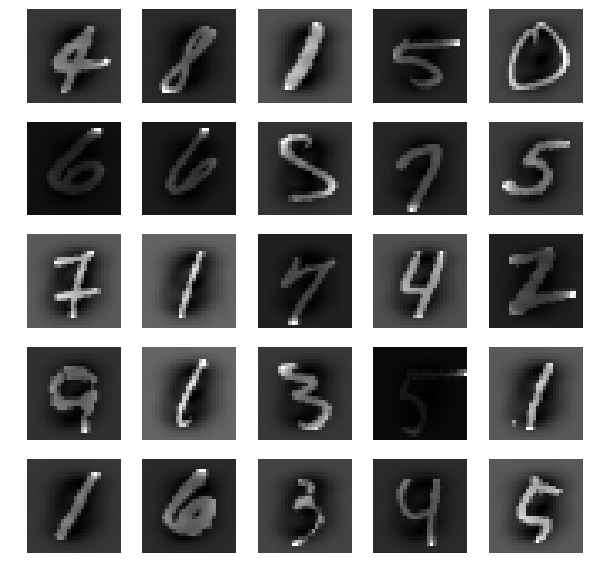

In [3]:
# %load mnist_vis_train.py
fig = plt.figure(figsize=(10,10))
(num_rows, num_cols) = (5, 5)
for i in range(0, num_rows * num_cols):
    img = X_train[i].reshape(28, 28)
  
    ax  = fig.add_subplot(num_rows, num_cols, i+1)
    _ = ax.set_axis_off()
    
    _ = plt.imshow(img, cmap="gray")


Train the model

In [4]:
# %load mnist_train.py
X_train.shape, y_train.shape

# Turn up tolerance for faster convergence
mnist_lr_clf = LogisticRegression(C=50. / train_samples,  # n.b. C is 1/(regularization penalty)
                         multi_class='multinomial',
                         # penalty='l1',   # n.b., "l1" loss: sparsity (number of non-zero) >> "l2" loss (dafault)
                         solver='saga', tol=0.1)

t0 = time.time()

# Fit the model
mnist_lr_clf.fit(X_train, y_train)

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)


((5000, 784), (5000,))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.1, verbose=0, warm_start=False)

Example run in 3.780 s


Examine the score (n.b., ran with L2 penalty)

In [5]:
# How many zero coefficients were forced by the penalty ?
sparsity = np.mean(mnist_lr_clf.coef_ == 0) * 100
score = mnist_lr_clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)

print("Sparsity with {p} penalty: {s:.2f}.".format(p=mnist_lr_clf.penalty, s=sparsity) )
print("Test score with {p} penalty:{s:.4f}".format(p=mnist_lr_clf.penalty, s=score) )

Sparsity with l2 penalty: 15.69.
Test score with l2 penalty:0.8775


### Aside: Cross-validated score

In [6]:
# Use cross-validation to get scores
from sklearn.model_selection import cross_val_score
cross_val_score(mnist_lr_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87073609, 0.86314526, 0.86229705])

87% accuracy.

- Are we done ?
    - Is 87% "good"

Let's predict, using the test data.  Introduce the confusion matrix

In [7]:
# Now predict the value of the digit on the second half:
expected = y_test
predicted = mnist_lr_clf.predict(X_test)

confusion_mat = metrics.confusion_matrix(expected, predicted)


In [8]:
# %load mnist_plot_confusion.py
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        # Normalize by row sums
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around( 100 * cm_pct, decimals=0).astype(int)
        
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Plot coordinate system has origin in upper left corner
        # -  coordinates are (horizontal offset, vertical offset)
        # -  so cm[i,j] should appear in plot coordinate (j,i)
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Here is the confusion matrix, both in count and percent.

Confusion matrix, without normalization


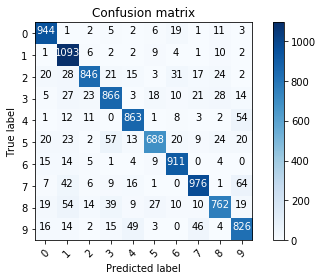

In [9]:
plot_confusion_matrix(confusion_mat, range(10))

Normalized confusion matrix


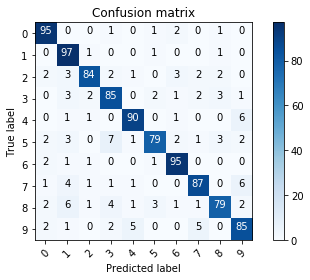

In [10]:
plot_confusion_matrix(confusion_mat, range(10), normalize=True)

- You can see that we didn't do equally well for all digits
    - "5", "8": below 80% correctly classified
    - "2", "3", "9": 80%-90% correctly classified
    
- Questions:
    - Are the errors acceptable ?
    - What can we do about the errors ?

Plot the mis-classified problem digits

In [11]:
problem_digits = [ '5', '8', '2', '3', '9' ]

def plot_problem_digits(problem_digits):
    """
    Plot mis-classified digits
    
    Parameters
    ----------
    problem_digits: List of characters.  Each element of list is a digit
    
    For each digit T in list: find the test set examples where true label is T but is classified otherwise.
    Plot the mis-classified test examples
    """
    # Dimensions of plot grid
    num_rows, num_cols = len(problem_digits), 5
    fig = plt.figure(figsize=(2*num_cols, 2*num_rows))
    
    # Plot examples for each problem digit
    for i, digit in enumerate(problem_digits): 
        # Find the mis-classified test obsevations for this digit
        mask = (expected == digit) & (expected != predicted)
        X_misclassified = X_test[mask]
        y_misclassified = predicted[mask]
        num_misclassified = X_misclassified.shape[0]
        
        # Plot the mis-classified instance of digit
        plot_num = num_cols * i
        for j in range(0, min(num_cols, num_misclassified)):
            # Get the X, y for the mis-classified image
            img = X_misclassified[j].reshape(28,28)
            pred =   y_misclassified[j]
            
            # Plot the image
            ax = fig.add_subplot(num_rows, num_cols, plot_num + j +1)
            _ = ax.set_axis_off()
    
            _ = plt.imshow(img, cmap="gray")
            _ = ax.set_title("Pred: {c:s}, Class: {t:s}".format(c=pred, t=digit))

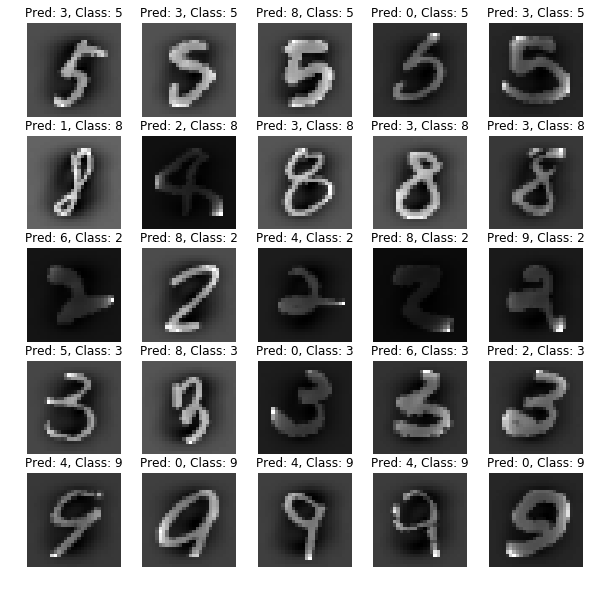

In [12]:
plot_problem_digits( problem_digits )

- Now that you can visualize the "problems", can you think of ways to improve the prediction ?

### Detailed metrics for clasification

**Note** For simplicity we will illustrate with binomial classification.

To expand to multinomial: just consider "one versus all" binary classifiers.

**Accuracy**, the fraction of correct predictions.


$$
\textrm{Accuracy} = \frac{\textrm{number of correct predictions}}{\textrm{number of predictions} }
$$

We can categorize our predictions by comparing actual target with predicted target:
- Correct predictions (Actual == Predicted) 
    - for each class (classes called "Positive" and "Negative")
    - True positives (TP)
    - True negatives (TN)
- Incorrect predictions (Actual != Predicted) for each class
    - False Positive (FP)
    - False Negatives(FN)

In pictures:
$$
\begin{array}{rll}
\\
& \textrm{Predicted} \\
           & \textbf{P} &  \textbf{N} \\
\textrm{Actual }\textbf{P} & TP         & FN \\
\textbf{N} & FP        & TN \\
\end{array}
$$

So

$$\textrm{Accuracy} =  { \text{TP} + \text{TN} \over  \text{TP} + \text{FP} + \text{TN} + \text{FN} } $$

Binary classifier

- Create a binary classifier for a single MNIST digit

In [13]:
def make_binary(digit, y_train, y_test):
    """
    Turn multinomial target into binary target
    
    Parameters
    ----------
    digit: Character.  Value of digit on which to make target binary: "Is digit"/"Is NOT digit"
    y_train, y_test: ndarrays.  Train/test target values
    
    Returns
    -------
    Tuple (y_train, y_test)
    """
    y_train_d = ( y_train == digit)
    y_test_d  = ( y_test  == digit)
    
    return  y_train_d, y_test_d

digit = '5'
y_train_d, y_test_d = make_binary(digit, y_train, y_test)


In [14]:
# Fit the model
mnist_lr_clf.fit(X_train, y_train_d)
cross_val_score(mnist_lr_clf, X_train, y_train_d, cv=3, scoring="accuracy")

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(mnist_lr_clf, X_train, y_train_d, cv=3)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.1, verbose=0, warm_start=False)

array([0.93405276, 0.93997599, 0.94777911])

In [15]:
y_scores = cross_val_predict(mnist_lr_clf, X_train, y_train_d, cv=3,
                             method="decision_function")

#### Precision
A metric to tell you the fraction of your Positive predictions that were correct.

$$
\textrm{Precision} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FP} }  }
$$

There is a degenerate case of perfect precision:
- predict "Positive" for only a single, known actual positive
- 100% precision, but you fail to correctly predict most actual positives

#### Recall, True Positive Rate

**aka, Sensitivity**

Fraction of Actual Positives that are classified as Positive 
$$
\textrm{Recall} = \textrm{TPR} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FN} }  }
$$

This pushes against Precision by trying to predict more actual positives.



#### Precison/Recall Tradeoff

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_d, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    _ = plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    _ = plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    _ = plt.xlabel("Threshold", fontsize=16)
    _ = plt.legend(loc="upper left", fontsize=16)
    _ = plt.ylim([0, 1])

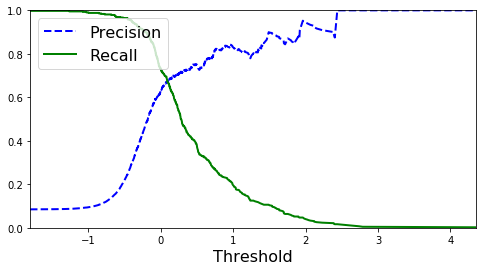

In [17]:
_ = plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
_ = plt.xlim([ thresholds.min(), thresholds.max()])

_ = plt.show()

**Precision vs Recall: which one to favor ?**

- Depending on the context, you may favor Precision over Recall, or vice-versa:
    - Favor Precision when a False Positive is undesirable
        - FP: mistakenly tell someone they are in trouble
    - Favor Recall when False Negative is undesirable
        - FN: mistakenly fail to identify a highly-communicable disease

#### $F_1$: Another way to combine Precision and Recall

Combines Precision and Recall

$$
\textrm{F}_1 = { { \textrm{TP} } \over { \textrm{TP} +  { { \textrm{FN} + \textrm{FP} }   \over 2 } }  }
$$

#### ROC: Motivation


Recall that, the `LogisticRegression` based classifier converted a score into a probability using the sigmoid function ($\sigma$), and based our prediction
on whether the probability was above/below a threshhold of 50%:

$$ h_\theta(x) = \sigma( s )$$ 

Probability 

$$ \hat{p} = h_\theta(x) = \sigma(s)$$

Prediction

$$
\hat{y} = 
\left\{
    {
    \begin{array}{lll}
    0 & \textrm{if } \hat{p} < 0.5 \\
    1 & \textrm{if } \hat{p} \ge 0.5
    \end{array}
    }
\right.
$$

- What if we lowered the threshhold ?
    - We would classify more observations as Positive
        - May increase TP (recall) but also FP (decrease precision)
- What if we raised the threshhold ?
    - We would classify fewer observations as Positive
        - May decrease TP (recall) but also FP (increase precision)
        - Degenerate case: identify only a single TP so perfect precision but hardly any recall !

A few more bits of jargon (unfortunate, but ultimately used in the ROC)

#### Specificity, True Negative Rate

$$
\textrm{Specificity} =  \textrm{TNR} = { { \textrm{TN} } \over { \textrm{TN} +  \textrm{FP} }  }
$$

#### False Positive Rate
$$
\begin{array}{lll}
\textrm{FPR} & = & { { \textrm{FP} } \over { \textrm{FP} + \textrm{TN} } } \\
             & = & 1 - \textrm{Sensitivity}
\end{array}
$$

The **ROC** plots the TPR versus the FPR.

We illustrate the ROC by converting the mult-digit MNIST classifier into a binary classifier for a single digit.
- Create a binary classifier for a single MNIST digit
- Plot the ROC

#### ROC

Plot TPR vs FPR

- Vary the $\hat{p}$ cut-off
    - Compute True Positive Rate and False Positive Rate
    - plot the trade-off
    - 45 degrees line is equal trade-off; want to be above the line
    - ROC curve is the plot of the trade-off
    

In [18]:
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, thresholds = roc_curve(y_train_d, y_scores)

def plot_roc_curve(ax, fpr, tpr, label=None):
    _ = ax.plot(fpr, tpr, linewidth=2, label=label)
    _ = ax.plot([0, 1], [0, 1], 'k--')
    _ = ax.axis([0, 1, 0, 1])
    _ = ax.set_xlabel('False Positive Rate', fontsize=16)
    _ = ax.set_ylabel('True Positive Rate', fontsize=16)




- Let's create a second model for binary classification so we can compare two models
- We will plot the ROC for each model so we can compare
- Goal: High TPR, Low FPR

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_d, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_d,y_scores_forest) 

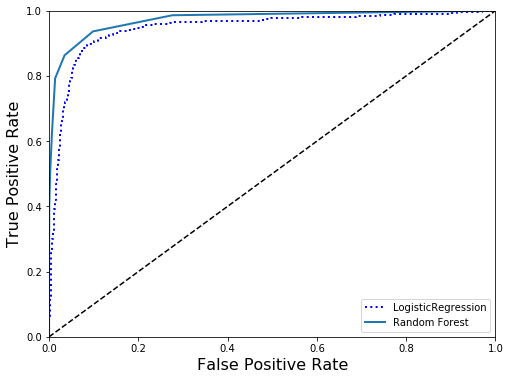

In [20]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(1,1,1)
_ = ax.plot(fpr_lr, tpr_lr, "b:", linewidth=2, label="LogisticRegression")

plot_roc_curve(ax, fpr_forest, tpr_forest, "Random Forest")
_ = ax.legend()


#### AUC
- Compare the ROC curves for two models
- Area under curve: the higher the better
    - choose model with higher AUC (absent any constraints on trade-off)



You can see from the pair of ROC plots that Random Forest has slightly greater AUC


## Regression: beyond RMSE/$R^2$

What is the Regression analog of the confusion matrix for examining errors ?

Examining the residuals.

The assumptins of Linear Regression is that the residuals:
- are normally distributed
- constant variance
- no pattern

Let's go back to our old example from a previous lecture: fitting a straight line to curvy data.

A simple plot of the residuals will show the problem.

n.b., A quantile-quantile (quantile of residual vs quantile of a normal distribution) plot can also be used


In [21]:
# %load recipe_regress.py
def plot_fit(X, y, ax=ax, on_idx=0):
    """
    Plot the fit
    
    Parameters
    ----------
    X: ndarray of features
    y: ndarray of targets
    ax: a matplotlib axes pbject (matplotlib.axes._subplots.AxesSubplot)
    
    Optional
    --------
    on_idx: Integer.  Which column of X to use for the horizontal axis of the plot
 
    """
    sort_idx = X[:, on_idx].argsort()
    X_sorted = X[ sort_idx,:]
    y_sorted = y[ sort_idx,:]
    
    _ = ax.plot(X_sorted[:, on_idx] , y_sorted, color="red")
    
def transform(X):
    """
    Add a column to X with squared values
    
    Parameters
    ----------
    X: ndarray of features
    """
    X_p2 = np.concatenate( [X, X **2], axis=1)
    return X_p2
    
def run_regress(X,y, run_transforms=False):
    """
    Do the full pipeline of the regression of y on X
    
    Parameters
    ----------
    X: ndarray of features
    y: ndarray of targets
    
    Optional
    --------
    runTransforms: Boolean.  If True, run additional data transformations to create new features
    """
    X_train, X_test, y_train, y_test = split(X,y)
    
    # Transform X's
    if (run_transforms):
        X_train = transform(X_train)
        X_test  = transform(X_test)

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    _ = regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: \n', regr.intercept_, regr.coef_)
    # Lots of predictions: predict on entire test set
    y_pred = regr.predict(X_test)

    # Explained variance score: 1 is perfect prediction
    print("R-squared (test): {:.2f}".format(r2_score(y_test, y_pred)) )

    y_pred_train = regr.predict(X_train)
    print("R-squared (train): {:.2f}".format(r2_score(y_train, y_pred_train)) )

    # Plot predicted ylabel (red) and true label (black)
    fig = plt.figure()
    ax  = fig.add_subplot(1,1,1)

    _ = ax.scatter(X_test[:,0], y_test, color='black')
    _ = ax.scatter(X_test[:,0], y_pred, color="red")

    # _ = ax.plot(X_test[:,0], y_pred, color="red")
    plot_fit(X_test, y_pred, ax=ax, on_idx=0)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel(ylabel)
    
    return

def plot_resid(X, y, y_pred):
    resid_curve = y - y_pred
    fig = plt.figure()
    ax  = fig.add_subplot(1,1,1)
    ax.scatter(X, resid_curve)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel("Residual")


Coefficients: 
 [11.25338949] [[0.95652077]]
R-squared (test): 0.75
R-squared (train): 0.92


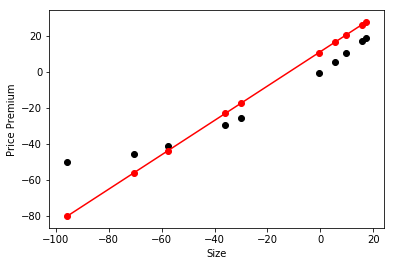

In [22]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import gen_data as gd
%aimport gen_data

(xlabel, ylabel) = ("Size", "Price Premium")
v1, a1 = 1, .005
v2, a2 = v1, a1*2
X_curve, y_curve = gd.gen_data(num=50, v=v2, a=a2)

from sklearn.model_selection import train_test_split
X_curve_train, X_curve_test, y_curve_train, y_curve_test = train_test_split(X_curve, y_curve, 
                                                                            test_size=0.20, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
_ = regr.fit(X_curve_train, y_curve_train)

# The coefficients
print('Coefficients: \n', regr.intercept_, regr.coef_)
# Lots of predictions: predict on entire test set
y_curve_pred = regr.predict(X_curve_test)

# Explained variance score: 1 is perfect prediction
print("R-squared (test): {:.2f}".format(r2_score(y_curve_test, y_curve_pred)) )

y_curve_pred_train = regr.predict(X_curve_train)
print("R-squared (train): {:.2f}".format(r2_score(y_curve_train, y_curve_pred_train)) )

# Plot predicted ylabel (red) and true label (black)
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

_ = ax.scatter(X_curve_test[:,0], y_curve_test, color='black')
_ = ax.scatter(X_curve_test[:,0], y_curve_pred, color="red")

# _ = ax.plot(X_test[:,0], y_pred, color="red")
plot_fit(X_curve_test, y_curve_pred, ax=ax, on_idx=0)
_ = ax.set_xlabel(xlabel)
_ = ax.set_ylabel(ylabel)
    


Let's plot the residuals of fitting a straight line to curvy data

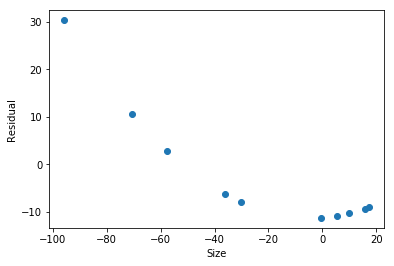

In [23]:
plot_resid(X_curve_test, y_curve_test, y_curve_pred)

Not good !
- clear pattern: errors increase in the tails
- not constant variance

Recall that our conclusion was that there was a missing feature: a higher order $x^2$ term.

Once we added that term, the target became linear in 
$$ \Theta^T \cdot X = \beta_1 *x + \beta_2 * x^2$$

## What is a "good" value for the performance metric

Consider the Accuracy Performance Metric applied to the MNIST classification problem
- Is 50% accuracy good for the 10-digit classifier ?
- Is 50% accuracy good for a single-digit (binary) classifier ?

One way to evaluate our model is to set up an extremely simple model as our "baseline" and compare our model's statistics to the baseline model.

### Some baseline models for classification

Most baseline classifiers choose a value from the Train target dataset `y_train` as the prediction.
The choice depends on the strategy

- Uniform
    - choose target from `y_train` using uniform random
- Most Frequent
    - choose target from `y_train`that occurs with highest frequency
- Stratified
    - choose target from `y_train` using distribution of `y_train`
- Constant
    - ignore `y_train`; return a constant
    

A bad baseline (e.g., constant, choosing the less frequent binary choice) can be really bad

In [24]:

from sklearn.dummy import DummyClassifier

strats = { "stratified": {}, 
          "uniform": {},
          "constant": {"constant": True}
         }
    
plt_num = 1

# Compute Accuracy for various baseline classifiers
for strat, args in strats.items():
    dmy_clf = DummyClassifier(strategy=strat, **args)
    acc_scores_dmy = cross_val_score(dmy_clf, X_train, y_train_d, cv=3, scoring="accuracy")
    
    print("{s}: Accuracy = {a:.2f}".format(s=strat, a=acc_scores_dmy.mean()))
   
  

stratified: Accuracy = 0.85
uniform: Accuracy = 0.50
constant: Accuracy = 0.08


### Digression: $R^2$ and the mean baseline model

$$ 
\begin{array}{ll}
R^2 & = & 1 - \left( \frac{\sum_{i=1}^m { (y_i - \hat{y}_i)^2} }{ \sum_{i=1}^m { (y_i -  \bar{y}_i)^2} }   \right) \\
& = & 1 - \left(  \frac{m \cdot \textrm{RMSE}(\hat{y}, y)^2} { \sum_{i=1}^m { (y_i -  \bar{y}_i)^2}} \right)
\end{array}
$$

Compares the MSE Performance Metric of a model to a baseline model that makes a constant prediction of the mean, $\bar{y}$

# Fixing/Improving a model

A deeper look at individual errors may have revealed a problem.
- What can we do ?
    - Throw away the model
    - Add features
    - Transform features
    - don't try to fit a square peg (non-linear target) into a round hole (linear model)
     

## Adding features

### LinearRegression on our "curvy" data set: adding a polynomial feature
Examining the errors of `LinearRegression` on the "curvy" data set showed a pattern and suggested a fix
- add polynomial features

**Lessons**
- Don't try to fit a square peg in a round hole
    - Simple linear model doesn't fit curvy data
    - Adding a feature makes the data linear (explain) in the new features

The plot of residual errors also revealed an even bigger problem: *Violation of assumptions* of Linear Regression
- residuals are normal
- residuals are homeskedatic: constant variance
    - bigger residuals in tails
    
So forcing a square peg into a round hole is not only not productive, it can be just plain wrong !

**Lesson**
Understand the requirements of your model and use it appropriately.

This is *not* a course on linear regression (highly recommend that you learn though !)
But it is a "go-to" model so we will try to find time to do a deeper dive on Linear Regression in the next lesson.

### Cross Features

- categorical
    - for each observation, create a True/False depending on pairs of features


## Transforming data (preview)

Another way to fix/improve your model is by data transformations.

There are many transformations and we will introduce a few in the next section.

But, as motivation:
- For a Linear model:
    - can you take a relationship that is not completely linear and make it more linear ?
        - Titanic: is survival probability linear in Age ?  
- For a model that wants normality
    - if the data is log-normal: take the log the the data
        - e.g. returns in Finance

Right now you only know 2 types of Regression models.  We'll digress and introduce another model, which is useful in its own right, but will also motivate one type of transformation.


- 

# K Nearest Neighbors: you are known by the company you keep

K Nearest Neighbors is a model that can be used for both Classification and Regression problems.
The concept is very simple: to make a prediction for feature vector $x$:
- Rank each observation in the Training Set by how "similar" its features are to $x$
- Choose the $k$ closest observations
- Prediction for $x$: the average of the targets for the $k$ observations closest to $x$
    - Classification: most frequent target among the $k$ targets
    - Regression: average across the $k$ targets


- Manifold Hypothesis
    - you are known by the neighbors you keep
- Applies even if you don't understand the features
- To predict given an observation with feature vector $x$:
    - compute "distance" between $x$ and each $x^{(i)}$ in the training set $X$
        - let $d^{(i)}$ denote distance between $x$ and $x^{(i)}$
    - Let $C$ be the sequence of observations $(x^{(i)}, y^{(i)})$ in increasing order of $d^{(i)}$ 
    - prediction: the average of $\{ y^{(i)} | i \in C[0:k] \}$
        

## Measures of similarity

### Euclidean distance

$$
||A||^2 = A \cdot A
$$

so
$$
||A|| = \sqrt{ A \cdot A }
$$

$$
\textrm{dist}(A, B) = { A \cdot B } 
$$

### Cosine similarity of two vectors
$$
\textrm{sim}(A, B) = \cos(\theta) = \frac{ A \cdot B } { || A || \times|| B || }
$$

So cosine similarity is distance of normalized $A = \frac{A}{||A||}$ and normalized $B = \frac{B}{||B||}$

The difference between Euclidean and Cosine similarity is analagous to the difference between
Covariance and Correlation from statistics
- Covariance is unscaled
- Correlation is normalized
- Correlation can be shown to be the covariance of standardized variables

For zero mean $A, B$:
$$
\textrm{cov}(A,B) = { 1 \over m } \times A \cdot B
$$

$$
\begin{array}{lll}
\textrm{corr}(A,B) & = &  \frac{ { 1 \over m } \times A \cdot B }{ {\frac{1}{\sqrt{m}}  \times ||A||} \times {\frac{1}{\sqrt{m}}  \times ||B||} } \\
                   & = &\frac{ A \cdot B } { ||A|| \times ||B||}
\end{array}
$$

**Note**
In the above, $A, B$ are *vectors* (one point in $m$ dimensions) whereas below, $A, B$ are each *sequences* of $m$ scalars (i.e, $m$ one-dimensional points)

So $\textrm{corr}(A,B)$ is covariance of normalized $A = \frac{A}{||A||}$ and normalized $B = \frac{B}{||B||}$

And
$$
\textrm{corr}(A, B) = \cos (\theta)
$$
[see](http://people.sju.edu/~pklingsb/dot.cov.pdf)

Let's illustrate KNN to classify some random data.

## Example

In [25]:
def stretch_ds(ds, mag):
    """
    Stretch a dataset by scaling the features
    
    Parameters
    ----------
    ds: Tuple (X,y)
    - X are the features, y are the targets
    -- X: ndarray.   Two dimensional
    
    mag: ndarray. One dimensional.  Length matches second dimension of X

    Returns
    --------
    Xprime: ndarray
    - same dimension as X
    - each column of X is multiplied by the corresponding magnitude in mag
 
    """
    (X, y) = ds
    Xprime = X * mag
    
    return (Xprime, y)

In [26]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", 
         "Decision Tree", "Random Forest"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    ]

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
   
def plot_scatter(ax, X, X_train, X_test,  y_train, y_test, ds_cnt):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
  
    if ds_cnt == 0:
        ax.set_title("Input data")
        
    # Plot the training points
    _= ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    _= ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    _= ax.set_xlim(xx.min(), xx.max())
    _= ax.set_ylim(yy.min(), yy.max())
    #_= ax.set_xticks(())
    #_= ax.set_yticks(())
    
    _ = ax.set_xlabel("Feature 1")
    _ = ax.set_ylabel("Feature 2")
    
    return (xx, yy)
    
def plot_countour(ax, Z, X_train, X_test, y_train, y_test, xx, yy, name, score, ds_cnt):
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    _= ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    _= ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    _= ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.6)

    _= ax.set_xlim(xx.min(), xx.max())
    _= ax.set_ylim(yy.min(), yy.max())
    #_= ax.set_xticks(())
    #_= ax.set_yticks(())
    
    _ = ax.set_xlabel("Feature 1")
    _ = ax.set_ylabel("Feature 2")
    
    if ds_cnt == 0:
        _= ax.set_title(name)
    _= ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    
    

In [27]:

    
def plot_classifiers(names, classifiers, num_samples=100, scale=True, num_ds=1):
    X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                               random_state=1, n_clusters_per_class=1)
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)

    moons_ds = make_moons(noise=0.3, random_state=0, n_samples=num_samples)
    
    datasets = [ moons_ds,
                stretch_ds(moons_ds, np.array([10,1])),
                make_circles(noise=0.2, factor=0.5, random_state=1, n_samples=num_samples),
                linearly_separable
                ]

    # Short version: limit classifiers and datasets to num_ds
    names, classifiers, datasets = [ a[:num_ds] for a in [names, classifiers, datasets] ]
    figure = plt.figure(figsize=(12,6))
    i = 1
    # iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        # preprocess dataset, split into training and test part
        X, y = ds

        # CHEATING ALERT: scaling BEFORE train/test split so info from test leaks into train
        if scale:
            X = StandardScaler().fit_transform(X)
            
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=.4, random_state=42)

        xx, yy = plot_scatter(ax, X, X_train, X_test,  y_train, y_test, ds_cnt)
        i += 1

        # iterate over classifiers
        for name, clf in zip(names, classifiers):
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            plot_countour(ax, Z, X_train, X_test, y_train, y_test, xx, yy, name, score, ds_cnt)
            i += 1

    plt.tight_layout()
    return (names, classifiers, datasets)
  

Illustrate how KNN binary classifier works
- two features
    - similar scale (see axes range)
- targets are binary
- show with features scaled/unscaled
    - not much difference

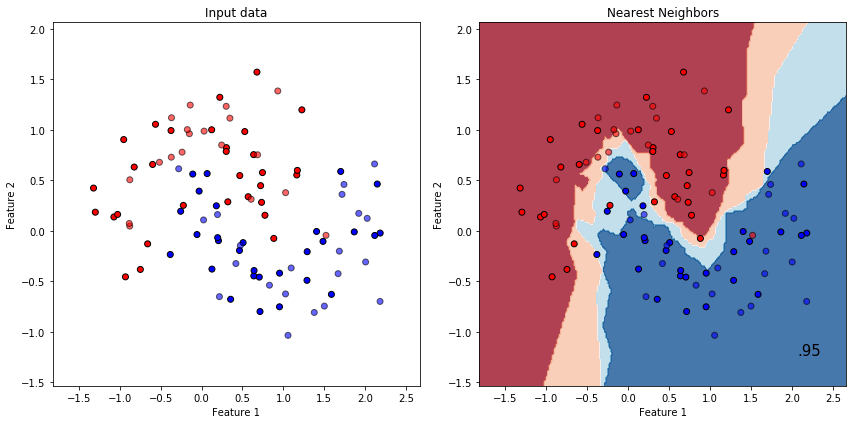

In [28]:
_= plot_classifiers(names, classifiers, scale=False)


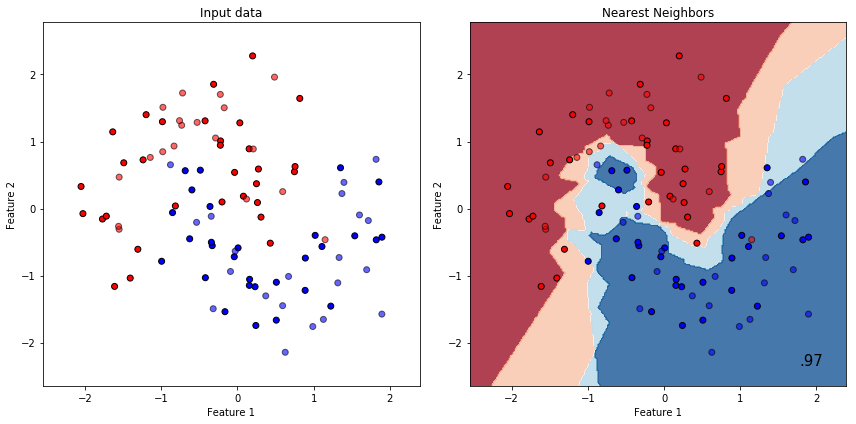

In [29]:
_ = plot_classifiers(names, classifiers, scale=True)

- What happens if the two features are **not** on the same scale 
- Why do the plots of the unstretched/stretched datasets look the same ?
    - plot package is scaling the axis to improve display !
- Drastically different KNN classification
    - score decreases quite a bit
- Decision tree classifier doesn't seem to care

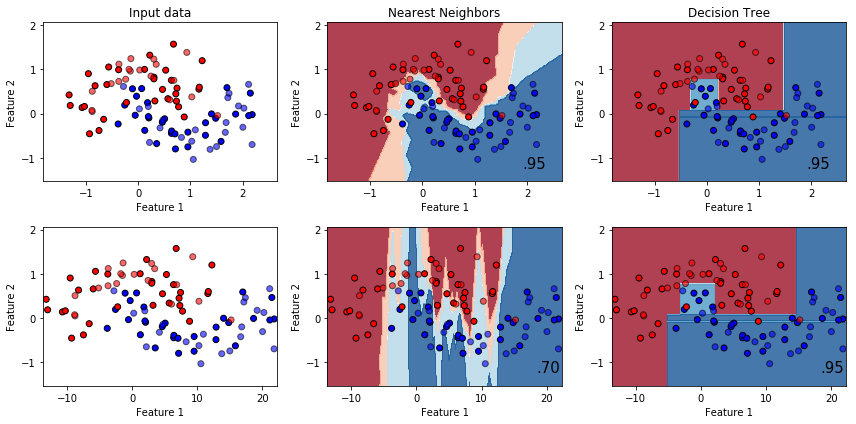

In [30]:
_ = plot_classifiers(names, classifiers, scale=False, num_ds=2)

- Why did stretching Feature 1 matter for KNN with no scaling ?
    - Look at Euclidean distance measure
    - What did scaling accomplish ?

# Transformations

Having seen the effect of features with different scales on one classifier (KNN), we have sufficient motivation
for our first class of transformations

Note that transformations may be applied
- to features
- to targets
- to both features and targets

## Caveats on transformations
- **Remember** If you scale the Train data, you must apply the same transformation to Test data
    - fit on *train only*

- If you transform the target
    - the prediction will be in "transformed" space
    - need a reverse transformation to put transformed target back into "raw" space
    
Rransformations in sklearn can be
- fit once (to train)
- applied (via the `transform` method) to test
- reversed (via the `inverse_transfoorm` method)

## Feature Scaling

Put features on similar scale

- some models are sensitive to feature magnitude


### Example KNN

See above.  Compare the fit when features are normalized versus when they are not normalized.

### Example: Regularization penalty

- if $ x_1 \approx 10 x_2$, then $\beta_{x_1} = .1 \beta_{x_2}$
    - does that make $x_1$ "less important" because of smaller beta ?
- $\beta_i = { \partial(y) \over \partial{x_i} }$
    - $\beta_i = y(x+1) - y(x)$
        - a move of $1$ is huge for small range $x$ and tiny for huge range $x$

#### [Ridge Regression](external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Ridge-regression-%28$L_2$-Regularization%29)
​
Penalty is: sum (over parameters) of squared paramter value
​
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
​
Also known as $L_2$ regularizer.
​
This tends to push parameters $\theta_n$ towards smaller values.

#### [Lasso Regression][1]
[1]: external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Lasso-regression-($L_1$-regularization)


Penalty is: sum (over parameters) of parameter's absolute value
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$

Also know as the $L_1$ regularizer.


## Centering

Transforming a feature to have mean $0$.

$$
\hat{x}^{(i)} = { x^{(i)} - \bar{x} }
$$

- star rating
- some algos (PCA) need centered data

## Normalization

### Motivation, examples

- Centering
    - 5 star ratings
        - 1 star very negative, 5 very positive
            - uncentered (1 to 5) makes coefficients harder to interpret (intercept has to handle the centering)
    - incremental effect vs total effect
    

  

### Standardize (z-score)

$$
\hat{x}^{(i)} = { { x^{(i)} - \bar{x} } \over { \sigma_x} }
$$

### MinMax

Covert to $[0,1]$ range.

$$
\hat{x}^{(i)} = { { x^{(i)} -  \textrm{min}_x } \over { \textrm{max}_x - \textrm{min}_x } }
$$


### Ratio

- Pooling
    - more than putting on same numeric scale: put on same *logical* scale
    - Put on same basis vs time
        - time-varying data
        - pre/post split
        - drifting data: Price or Income levels (normalize by GDP, Deflator)

    - Put on same basis vs, e.g. units, like currency
        - convert to same currency 

- Pooling (continued)
    - Put on same basis vs cross-section
    - Price to return
    - Price/income levels across multiple countries
        - just converting to common currency not enough
        - normalize to GDP, etc

## Log transformation

### Logistic Regression as Linear Regression with a Log Transformation

- Log of the odds ratio is normally distributed
- So errors are normally distributed and satisfy the assumptions of `LinearRegression`


/home/kjp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/kjp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


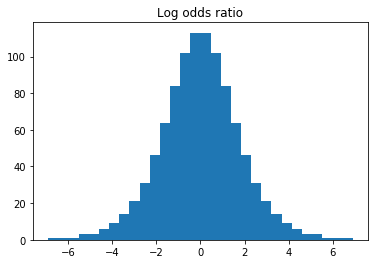

In [31]:
p = np.linspace(0,1, 1000)

# Note: add epsilon to denominator to prevent division by 0
eps = 1e-6
odds = p/(1-p + eps)
log_odds = np.log( odds )

fig, axes = plt.subplots(nrows=1, ncols=1)
ax = axes

# Drop the first/last points b/c they are infinite
_ = ax.hist( np.log(odds)[1:-1], bins=30 )
_ = ax.set_title("Log odds ratio")

$$
\begin{array}{llll}
\hat{p} \over {1- \hat{p}} & = &  { 1 \over { 1 + e^{-s} } } \over { 1 -  {1 \over { 1 + e^{-s} } } } \\
& = & { 1 \over { 1 + e^{-s} } } \over { {1 + e^{-s}  -1} \over {1 + e^{-s}} } \\
& = & 1 \over {e^{-s}} \\
& = & e^{s}
\end{array}
$$



So `LogisticRegression` is really just a `LinearRegression` with a transformed target

$$
\textrm{log}( {\hat{p} \over {1- \hat{p}}}) = \Theta^T \cdot x
$$

## Bucketing/Binning

- Target may be linear in a feature only in broad ranges of the feature
    - income vs age
        - very young (below working age) all income is identical (0)
        - very old (above retirement) - no job related income
    - Latitude/Longitude
        - small changes matter MUCH less than big changes
        
- Converts numerical feature into categorical
    - or numeric using center of bin

- Equal spaced buckets
- Equal quantile buckets

**Lesson** Don't fit a square peg (non-linear response) into a round hole (linear model)

## Outliers

Pull in extreme values to reduce their influence on the fit.

- Clipping, Winsorization


# Missing Values

What can we do about missing values among the features in the Train and Test data sets ?

- Drop the entire observation
    - Loses potentially useful data
    
- Drop the feature from the entire dataset
    - Lose even more data
    
- Create a substitute value for the missing feature in an observation

We will explore the latter.



There are some subtitutions that are better than others. Consider the following possible substitutes
- Awful
    - -9999, i.e, some visually outstanding value
    - 0
- Naive
    - mean
    - median
- Predictive

In order to evaluate our options, let's articulate some goals

- Univariate
    - substitute value plausible relative to the distribution of values for the feature
        - mean, median
- Multivariate
    - substitute is plausible in the context of the values for the other features in the observation
        - consider two perfectly negatively correlated features
        - a subsitute that ignores this is less than ideal
- Don't bias the prediction  

Your goal is to create a substitute so that you can get *some* value out of the observation without influencing the prediction too much.

## Naive methods

Suppose our ML algorithm works (like KNN) using a distance metric.

The following example shows the difference in cosine similarity using 3 different approaches for substitution:
- zero
- mean
- centering, followed by 0

Data:
- Each row is a student
- Each column is the student's rating of a professor (scale 0 to 5)
- KNN will ultimately use the filled-in data to measure similarity of students, based on their ratings

In [32]:
import pandas as pd
import numpy as np

S1 = pd.Series( { "a": 4,               "d": 5, "e":1 })
S2 = pd.Series( { "a": 5, "b":5, "c": 4})
S3 = pd.Series( {                       "d": 2, "e": 4, "f": 5})

df = pd.DataFrame( [S1, S2, S3], index=["A", "B", "C"])


A = df.loc["A",:]
B = df.loc["B",:]  
C = df.loc["C",:]


def sim(A, B):
    """
    Compute cosine similarity of vectors A and B
    
    Parameters
    -----------
    A, B: ndarrays of same length
    """
    return (A * B).sum()/( np.sqrt( (A*A).sum() ) * np.sqrt( (B*B).sum() ) )

def compare_subs(X, Y):
    """
    Compare various ways of filling in missing values 
    
    Parameters
    ----------
    X, Y: ndarrays of equal length
    """
    (Xp, Yp) = (X.fillna(0), Y.fillna(0))
    print("\tSubstitute 0: similarity= {s:0.2f}".format(s= sim( Xp, Yp )) )

    # Substitute mean of each student
    (Xp, Yp) = (X.fillna( X.mean() ), Y.fillna( Y.mean() ))
    print("\tSubstitute respective mean: similarity= {s:0.2f}".format(s= sim( Xp, Yp  )) )

    # Center data, then substitute 0
    # Centered mean tells a different story (b/c of magnitudes of entries ?)
    # n.Y., Cov(X,Y) = E(X*Y) - E(X)E(Y) so is X, Y not centered, dot product is not Cov(X,Y)
    (Xp, Yp) = ( (X - X.mean()).fillna(0), (Y - Y.mean()).fillna(0) )
    print("\tCenter, then Substitute 0: similarity= {s:0.2f}".format(s= sim( Xp, Yp  )) )


In [33]:
df

,a,d,e,b,c,f
A,4.0,5.0,1.0,NaN,NaN,NaN
B,5.0,NaN,NaN,5.0,4.0,NaN
C,NaN,2.0,4.0,NaN,NaN,5.0


In [34]:

print("A vs B")
compare_subs(A,B)

print("A vs C")
compare_subs(A,C)


A vs B
	Substitute 0: similarity= 0.38
	Substitute respective mean: similarity= 0.94
	Center, then Substitute 0: similarity= 0.09
A vs C
	Substitute 0: similarity= 0.32
	Substitute respective mean: similarity= 0.87
	Center, then Substitute 0: similarity= -0.56


- A versus B
    - missing values are paired against relatively high values
        - Substituting $0$ (a low value) reduces similarity
        - Substituting mean (a relatively high value) increase similarity
            - A is a tougher rater: A.mean() < B.mean()
                
    - in the end, A and B had only a *single* true point of comparison ("a")
        - you made up the similarity

- A versus C:
    - *NO* professors in common !
    - But at least A and B are closer than A and C for some substitutions
    

Cosine similarity assumes centered data !
- $Cov(X,Y) = E(X*Y) - E(x)*E(Y)$
- Formula for cosine similarity assumes $E(X) = E(Y) = 0$

## Predictive methods for missing values

## Prediction from other features that are present
How do we get a substitute value for a feature that is consistent with the values for the other features in the observation ?

**Use Machine Learning !**

- Create a model to predict a feature $x_i$ from all the other (non-missing) features $\{ x_j | j \ne i \}$
    - Regression
    - Clustering (KNN again)
    

Clustering observations
- create a "distance metric" to measure the proximity of one feature vector to another
    - based on features that are present in both vectors
- to predict the $i^{th}$ feature of observation $A$ (feature $x^{(A)}_i$) that is missing 
    - drop feature $i$ from all feature vectors in Train set
    - measure distance from $x^{(A)}$ to all other $x^{(j)}, j \ne A$
    - the $k$ nearest observations to $A$ are it's cohort
        - use an aggregate value for feature $i$ from the cohort as the substitue for $x^{(A)}_i$

### Prediction from external featuers

- Create a model to predict a feature $x_i$ from external features that are correlated 
- Now-casting
 - derive higher frequency values for low frequency data
     - intra-year GDP
     - intra-month Economic statistics: Employment, Manufacturing
 - National Manufacturing employment may be highly correlated to Employment in a few states
     - state-level employment may be published
         - at higher frequency
         - earlier date
  - Many of these low frequency features are *composites* of other features
     - some elements of the composite are released before others
         - may predict the whole

   - [Now-casting site](https://www.now-casting.com/home)

# Data Augmentation



In [35]:
print("Done")

Done
